# gpt-image-1 on Azure AI Foundry - Image Compose

<img src="https://azure.microsoft.com/en-us/blog/wp-content/uploads/2025/04/Azure-AI-ML-Scene-3.png" width=300>

https://azure.microsoft.com/en-us/blog/unveiling-gpt-image-1-rising-to-new-heights-with-image-generation-in-azure-ai-foundry/?msockid=2e39c66c693c66a5151fd200687567d0

Source: https://github.com/Azure-Samples/visionary-lab/tree/main



In [1]:
import base64
import datetime
import os
import re
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from openai import AzureOpenAI
from PIL import Image

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
datetime.datetime.today().strftime('%d %b %Y %H:%M:%S')

'29 Apr 2025 16:00:50'

In [4]:
load_dotenv("azure.env")

api_version = "2025-04-01-preview"

In [5]:
model="gpt-image-1"

In [6]:
IMAGES_DIR = "images"

In [7]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

## 1. Compose a new image based on several input images

In [10]:
source_images = ["images/shirt.png", "images/trousers.png", "images/shoes.png"]

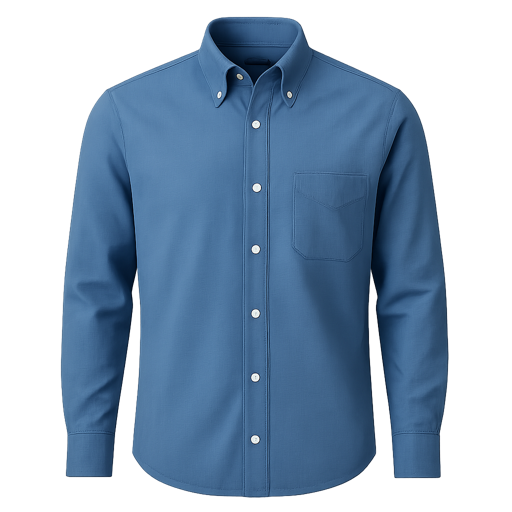

In [16]:
img1 = Image.open(source_images[0]).resize((512,512))
img1

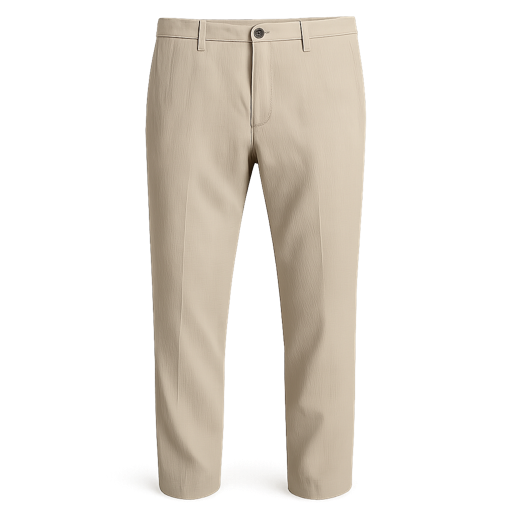

In [17]:
img2 = Image.open(source_images[1]).resize((512,512))
img2

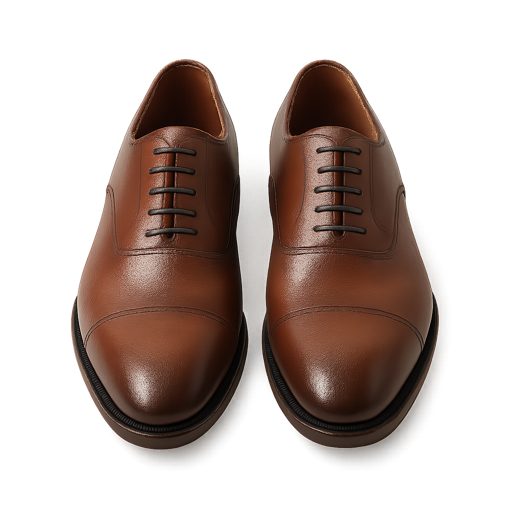

In [18]:
img3 = Image.open(source_images[2]).resize((512,512))
img3

In [14]:
def image_compose(source_images, prompt, n=1):
    """
    Composes a new image using multiple input images and a prompt via Azure OpenAI's image composition endpoint.

    Parameters:
        source_images (list[str]): List of file paths to the source images to be used for composition.
        prompt (str): Text prompt guiding the composition of the final image.
        n (int, optional): Number of composed images to generate. Defaults to 1.

    Returns:
        list[str] or None: A list of file paths to the saved composed images if successful,
                           or None if an error occurs during processing.

    The function:
        - Sends a multipart request with multiple source images and a prompt to the Azure image composition endpoint.
        - Parses and decodes the base64-encoded images returned in the response.
        - Displays and saves each composed image to a predefined results directory.
        - Returns a list of file paths to the generated images.
    """
    try:
        files = [("image[]", open(image, "rb")) for image in source_images]

        headers = {"api-key": os.getenv("key")}
        aoai_name = re.search(r'https://(.*?)/openai', os.getenv("endpoint")).group(1)
        url = f"https://{aoai_name}/openai/deployments/{model}/images/edits?api-version=2025-04-01-preview"
        
        data = {
            "prompt": prompt,
            "n": n,
            "size": "1024x1536",  # Options: 1024x1024, 1536x1024, 1024x1536
            "quality": "high",  # high, medium, low
        }

        response = requests.post(url, headers=headers, files=files, data=data)
        response.raise_for_status()

        images_data = response.json()["data"]
        encoded_images = [img["b64_json"] for img in images_data]

        # Parsing the generated images
        output_images_list = []

        for encoded_image in encoded_images:
            img = Image.open(BytesIO(base64.b64decode(encoded_image)))
            # Saving image to a file
            now = str(datetime.datetime.today().strftime("%Y%m%d_%H%M%S_%f")[:-3])
            output_file = os.path.join(RESULTS_DIR, f"compose_{now}.jpg")
            img.save(output_file)
            print(f"File saved: {output_file}")
            output_images_list.append(output_file)

    except Exception as e:
        print(f"Error generating images: {e}")
        return None

    return output_images_list

In [15]:
prompt = "Generate a photorealistic image of a man wearing the 3 items in the reference pictures (shirt, trousers, shoes). The man should walk in a busy street. We must see the Eiffel tower in the background."

images_list = image_compose(source_images, prompt, 3)

File saved: results/compose_20250429_160331_017.jpg
File saved: results/compose_20250429_160331_149.jpg
File saved: results/compose_20250429_160331_287.jpg


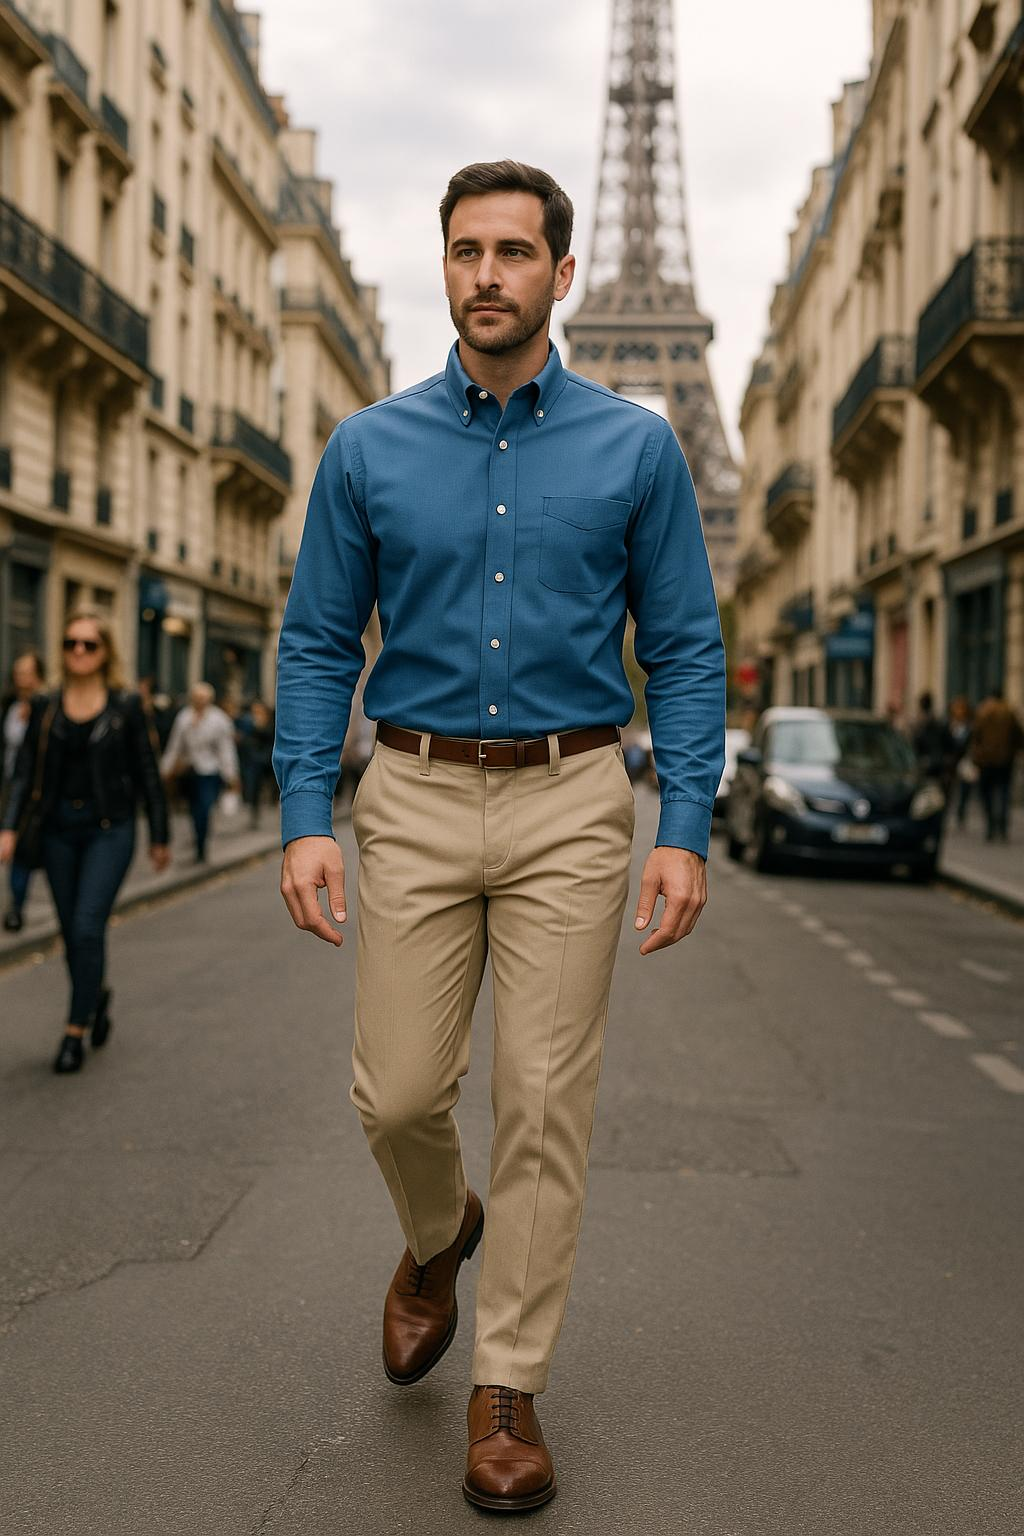

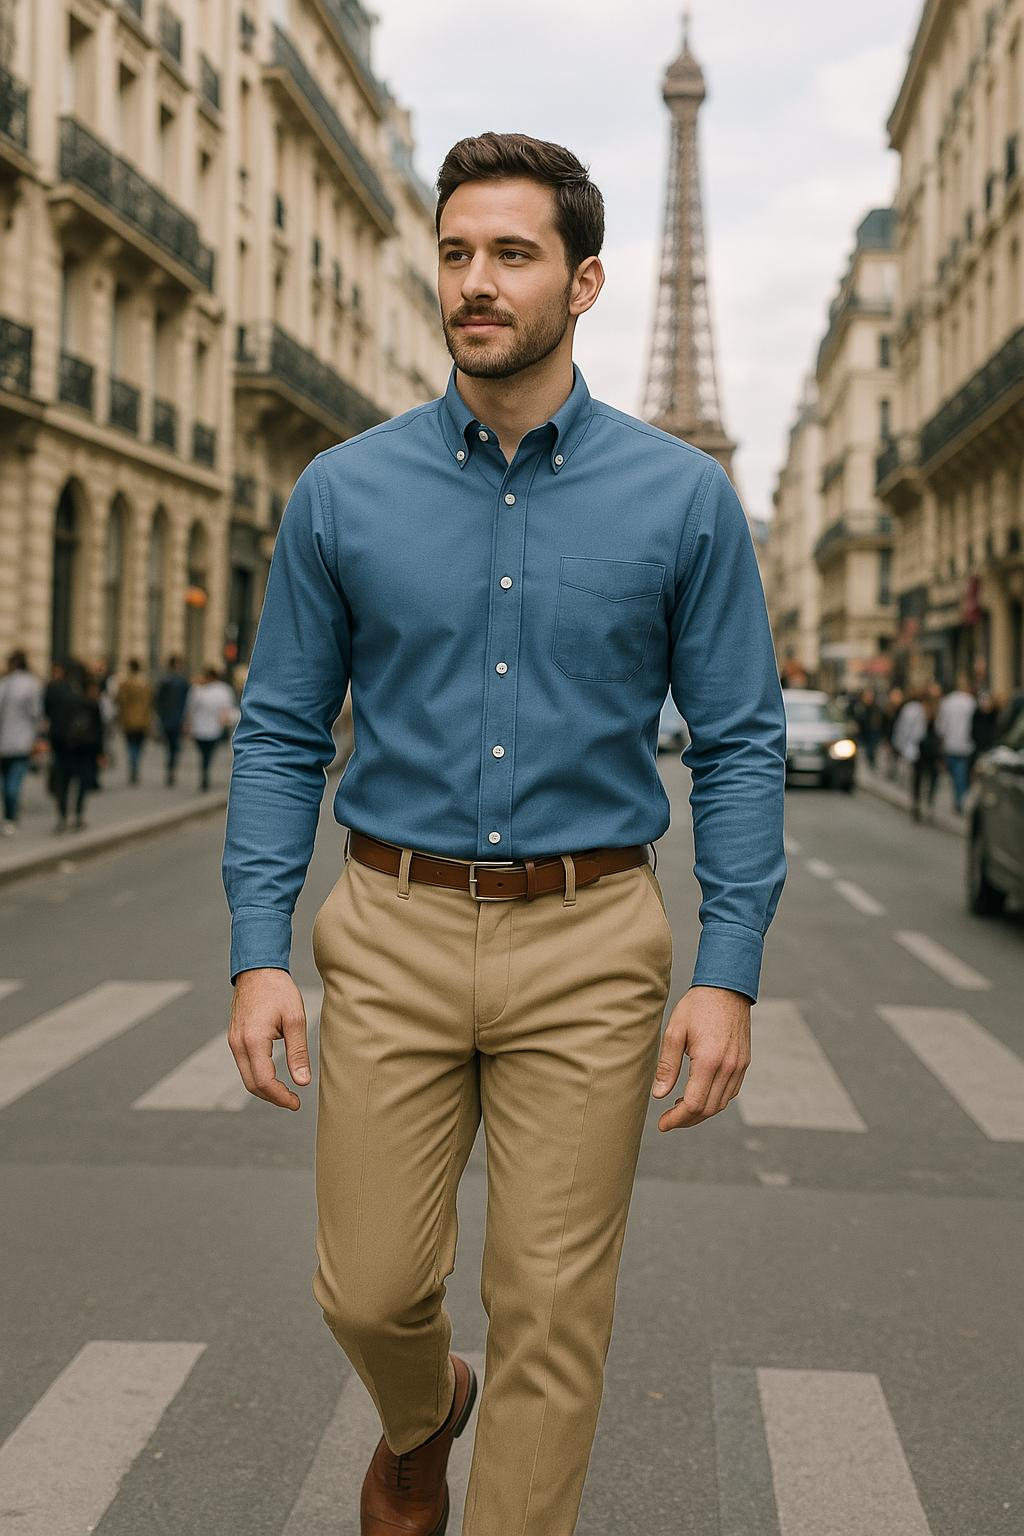

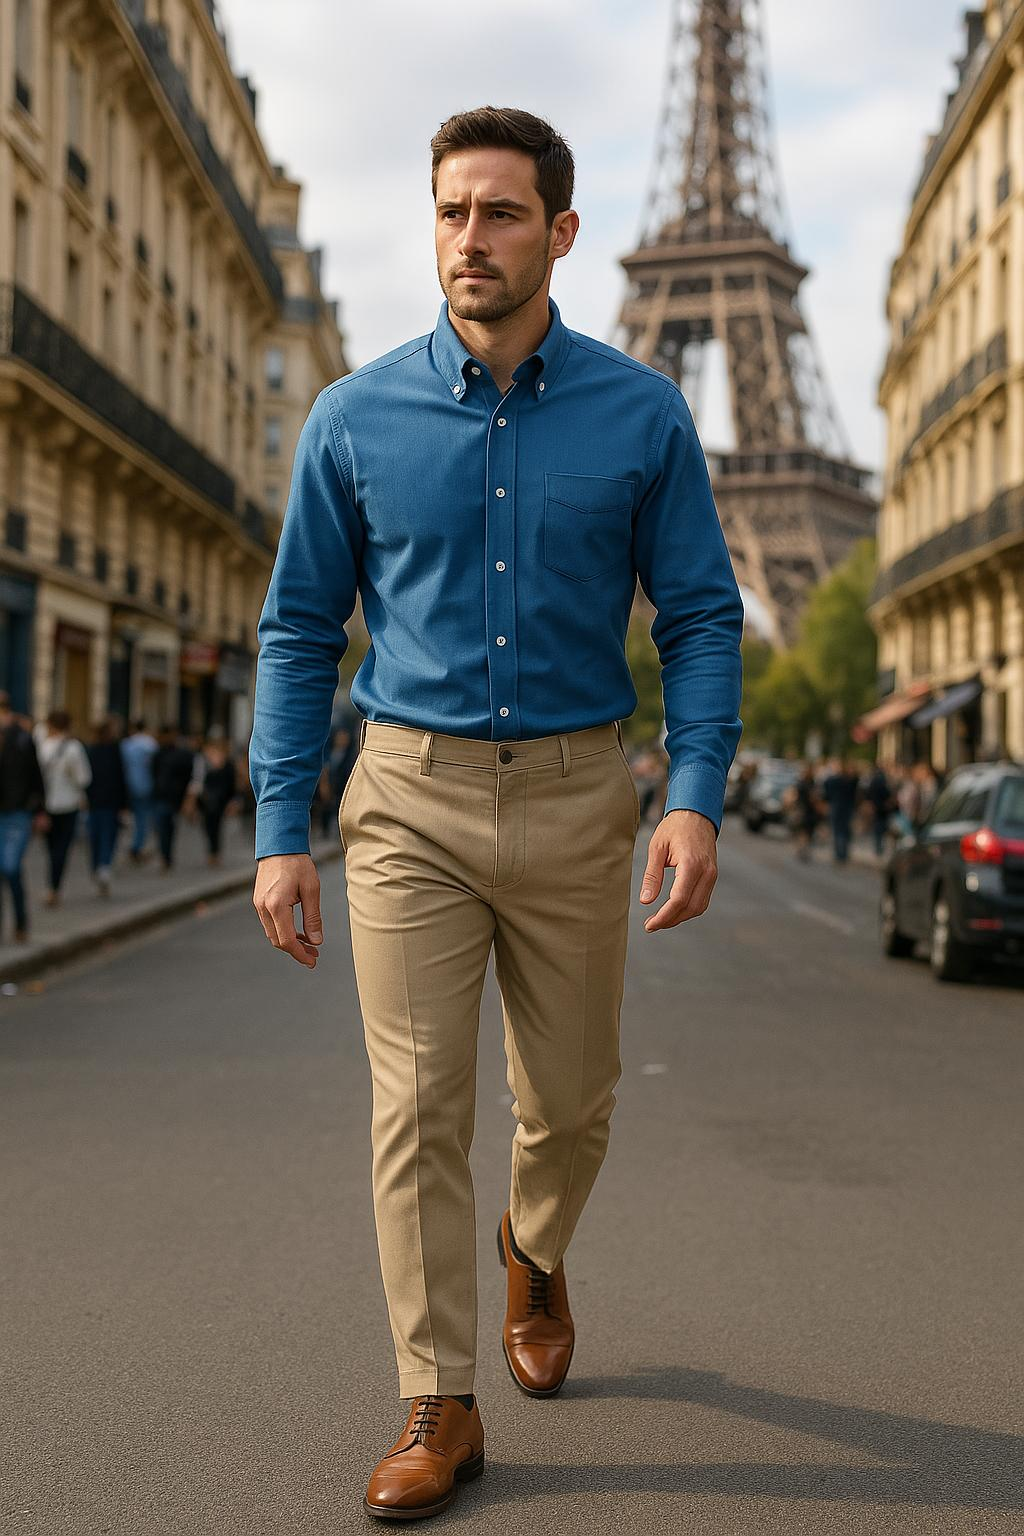

In [19]:
for i in range(len(images_list)):
    img = Image.open(images_list[i])
    display(img)